**Inportando dados**

In [170]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')
sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

from utils.dates import Dates

**Carregar a tabela de Projetos**

In [171]:
projetos_csv = os.path.join(DATA_FOLDER, 'projetos.csv')

cols = ['IdPRONAC', 'DtProtocolo', 'Situacao']

dt_projetos = pd.read_csv(projetos_csv, usecols = cols, low_memory = False)

dt_projetos.head()

,IdPRONAC,Situacao,DtProtocolo
0,1,E63,2008-09-12 00:00:00
1,2,G43,2008-09-12 00:00:00
2,3,K00,2008-09-12 00:00:00
3,4,E25,2008-09-03 00:00:00
4,5,E36,2008-09-12 00:00:00


**Separar projetos criados e projetos finalizados por ano**

In [172]:
years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
end_situations = ['A09', 'A13', 'A14', 'A16', 'A17', 'A18', 'A20', 'A23', 'A24', 'A26', 'A40', 'A41',
                  'A42', 'C09', 'D18', 'E04', 'E09', 'E47', 'E49', 'E63', 'E64', 'E65', 'G16', 'G25',
                  'G26', 'K00', 'K01', 'K02', 'L01', 'L02', 'L03', 'L04', 'L05', 'L06', 'L08', 'L10',
                  'L11']

created_projects = []
finished_projects = []

for year in years:
    project_created_after_begin_year = dt_projetos['DtProtocolo'] > '{}-01-01'.format(year)
    project_created_before_end_year = dt_projetos['DtProtocolo'] < '{}-12-31'.format(year)
    
    created_projects_filter = project_created_after_begin_year & project_created_before_end_year
    finished_projects_filter = created_projects_filter & dt_projetos['Situacao'].isin(end_situations)
    
    created_projects.append(len(dt_projetos[created_projects_filter]))
    finished_projects.append(len(dt_projetos[finished_projects_filter]))

    
created_projects_percentage = [0] + [(created_projects[i] - created_projects[i - 1]) * 100 / created_projects[i - 1] for i in range(1, len(created_projects))]
finished_projects_percentage = [0] + [(finished_projects[i] - finished_projects[i - 1]) * 100 / finished_projects[i - 1] for i in range(1, len(finished_projects))]

**Tabela de crescimento de projetos criados e finalizados**

In [173]:
def color_negative_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


data = {'Ano': years, 'Projetos Criados': created_projects, 'Projetos Criados %': created_projects_percentage,
        'Projetos Fechados': finished_projects, 'Projetos Fechados %': finished_projects_percentage}

df = pd.DataFrame(data = data)
dt = pd.DataFrame(data = data)

subset = pd.IndexSlice[:, ['Projetos Criados %', 'Projetos Fechados %']]

df = df.style.applymap(color_negative_red, subset = subset)

display(df)

,Ano,Projetos Criados,Projetos Criados %,Projetos Fechados,Projetos Fechados %
0,2009,9181,0,5159,0
1,2010,13532,47.3914,6863,33.0297
2,2011,14068,3.96098,5811,-15.3286
3,2012,10016,-28.803,4759,-18.1036
4,2013,11534,15.1558,5635,18.4072
5,2014,14419,25.013,5294,-6.05146
6,2015,11274,-21.8115,2795,-47.2044
7,2016,5097,-54.7898,1269,-54.5975
8,2017,9422,84.8538,3058,140.977


In [174]:
### Gráfico de projetos iniciados Vs projetos finalizados ao longo do tempo

Index(['Ano', 'Projetos Criados', 'Projetos Criados %', 'Projetos Fechados',
       'Projetos Fechados %'],
      dtype='object')

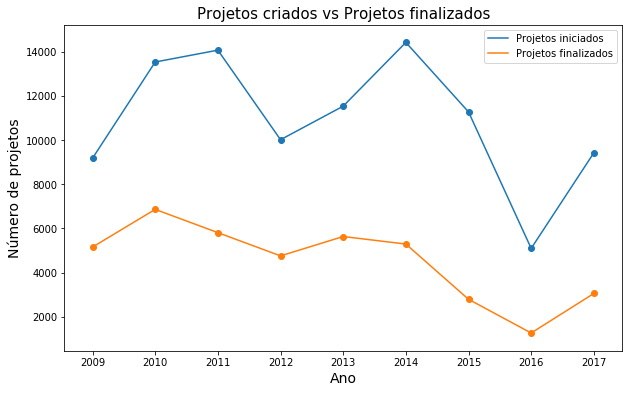

In [175]:
from scipy.interpolate import interp1d

display(dt.columns)
dt['Ano'] = pd.to_numeric(dt['Ano'])

years = dt['Ano'].values
created = dt['Projetos Criados'].values
finished = dt['Projetos Fechados'].values

#plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

plt.plot(years, created)
plt.plot(years, finished)
plt.scatter(years, created)
plt.scatter(years, finished)

plt.legend(['Projetos iniciados', 'Projetos finalizados'], loc='best')
plt.xlabel('Ano', fontsize = 14)
plt.ylabel('Número de projetos', fontsize = 14)
plt.title('Projetos criados vs Projetos finalizados', fontsize = 15)
plt.show()

In [176]:
def plot_1d_liner_regression(x, y, color = None, alpha = None):
    from sklearn import linear_model

    x = x.reshape(-1, 1)
    
    body_reg = linear_model.LinearRegression()
    body_reg.fit(x, y)

    prediction = body_reg.predict(np.sort(x, axis=0))

    plt.plot(np.sort(x, axis=0), prediction, color=color, alpha=alpha)

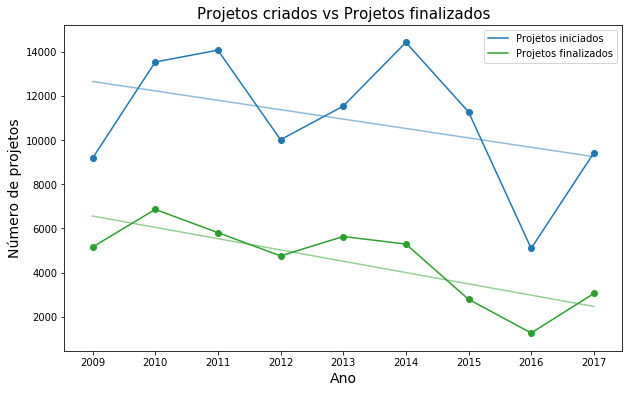

In [177]:
#plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

plt.plot(years, created)
plt.plot(years, finished, color='C2')
plt.scatter(years, created, color='C0')
plt.scatter(years, finished, color='C2')

plt.legend(['Projetos iniciados', 'Projetos finalizados'], loc='best')
plt.xlabel('Ano', fontsize = 14)
plt.ylabel('Número de projetos', fontsize = 14)
plt.title('Projetos criados vs Projetos finalizados', fontsize = 15)

plot_1d_liner_regression(years, created, color='C0', alpha=0.5)
plot_1d_liner_regression(years, finished, color='C2', alpha=0.5)

### Calculando a média do número de itens em uma planilha orçamentária aprovada

**Carregando a tabela com preços aprovados dos itens de todos os projetos**

In [178]:
tb_planilha_projeto_csv = os.path.join(DATA_FOLDER, 'tb_planilha_projeto.csv')
cols = ['idPRONAC',]

dt_planilha = pd.read_csv(tb_planilha_projeto_csv, usecols = cols, low_memory = False)

dt_planilha.head()

,idPRONAC
0,111109
1,111109
2,111109
3,111109
4,111109


**Adicionando data do projeto na planilha orçamentária**

In [179]:
dt_projetos = dt_projetos.set_index('IdPRONAC')
dt_planilha = dt_planilha.join(dt_projetos, on = ['idPRONAC'])
dt_planilha.head()

,idPRONAC,Situacao,DtProtocolo
0,111109,E36,2009-01-22 15:29:39
1,111109,E36,2009-01-22 15:29:39
2,111109,E36,2009-01-22 15:29:39
3,111109,E36,2009-01-22 15:29:39
4,111109,E36,2009-01-22 15:29:39


**Utilizando projetos somente com data de projeto maior ou igual a 2013**

In [180]:
from datetime import datetime
from utils.dates import Dates

START_DATE = datetime(day=1, month=1, year=2013)
date_column = 'DtProtocolo'
dt_planilha[date_column] = pd.to_datetime(dt_planilha[date_column], format = Dates.DATE_INPUT_FORMAT)
dt_planilha = dt_planilha[dt_planilha.loc[:, date_column] >= START_DATE]

**Projeto de exemplo para testar a data do projeto**

In [181]:
example_project = dt_planilha[dt_planilha.loc[:, 'idPRONAC'] == 210310]
display(example_project.head())
print('len(example_project) = {}'.format(len(example_project)))

,idPRONAC,Situacao,DtProtocolo
2241751,210310,E12,2017-07-27 11:06:04
2241752,210310,E12,2017-07-27 11:06:04
2241753,210310,E12,2017-07-27 11:06:04
2241754,210310,E12,2017-07-27 11:06:04
2241755,210310,E12,2017-07-27 11:06:04


len(example_project) = 123


### Média do número de itens em uma planilha orçamentária aprovada

In [187]:
from scipy import stats

unique, counts = np.unique(dt_planilha.idPRONAC.values, return_counts=True)

print('type(counts) = {}'.format(type(counts)))

for id, count in zip(unique, counts):
    if id == 210310:
        print('{}, {}'.format(id, count))

display(pd.DataFrame(counts).describe())

type(counts) = <class 'numpy.ndarray'>
210310, 123


,0
count,26413.000000
mean,48.281717
std,41.889854
min,2.000000
25%,26.000000
50%,39.000000
75%,57.000000
max,1286.000000
